In [ ]:
#|default_exp utils.io

# Utils

> Utility functions.

In [ ]:
#|export
import shutil, tempfile, pickle
import numpy as np
import polvo as pv
import uuid, json, mimetypes
from pathlib import Path
from fastcore.all import *
from PIL import Image, ImageOps

/home/lgvaz/git/polvo/polvo/utils/logging.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
#|export
def save_txt(s, path, append=False):
    mode = 'a' if append else 'w'
    with open(str(path), mode) as f: f.write(s)

In [ ]:
#|export
def open_txt(path):
    with open(str(path), 'r') as f: return f.read()
#     return np.loadtxt(path, dtype=str, delimiter="\n").tolist()

In [ ]:
with tempfile.NamedTemporaryFile() as f:
    s = 'There is nothing\nbut\nprogress\nto eat'
    save_txt(s, f.name)
    s_ = open_txt(f.name)
    equals(s, s_)
    
    #Test append
    save_txt('\nnew', f.name, append=True)
    s_ = open_txt(f.name)
    equals(s+'\nnew', s_)

In [ ]:
#|export
def open_json(path):
    with open(str(path)) as f: return json.load(f)

In [ ]:
#|export
def save_json(d, path):
    with open(str(path), 'w') as f: json.dump(d, f)

In [ ]:
with tempfile.NamedTemporaryFile() as f:
    d = {'pita': 'bread', 42: ['elden', 'ring']}
    save_json(d, f.name)
    d_ = open_json(f.name)
    equals(d, d_)

In [ ]:
#|export
def save_pickle(o, path):
    with open(path, 'wb') as file: pickle.dump(o, file)

In [ ]:
#|export
def open_pickle(path):
    with open(str(path), 'rb') as f: return pickle.load(f)

In [ ]:
with tempfile.NamedTemporaryFile() as f:
    s = ['There is nothing', 'but progress', 'to eat']
    save_pickle(s, f.name)
    s_ = open_pickle(f.name)
    equals(s, s_)

In [ ]:
#|export
def save_dill(o, path):
    import dill
    with open(path, 'wb') as file: dill.dump(o, file)

In [ ]:
#|export
def open_dill(path):
    import dill
    with open(str(path), 'rb') as f: return dill.load(f)

In [ ]:
with tempfile.NamedTemporaryFile() as f:
    s = ['There is nothing', 'but progress', 'to eat']
    save_dill(s, f.name)
    s_ = open_dill(f.name)
    equals(s, s_)

In [ ]:
#|export
def mkdir(path, exist_ok=False, parents=False, overwrite=False, tmp=False, **kwargs):
    "Creates and returns a directory defined by `path`, optionally removing previous existing directory if `overwrite` is `True`"
    path = Path(path)
    if tmp:
        path = tempfile.gettempdir() / path
        parents = True
    if path.exists() and overwrite: shutil.rmtree(path)
    path.mkdir(exist_ok=exist_ok, parents=parents, **kwargs)
    return path

In [ ]:
with tempfile.TemporaryDirectory() as d:
    path = Path(os.path.join(d, 'new_dir'))
    new_dir = mkdir(path)
    assert new_dir.exists()
    test_eq(new_dir, path)
        
    # test overwrite
    with open(new_dir/'test.txt', 'w') as f: f.writelines('test')
    test_eq(len(list(walk(new_dir))), 1) # assert file is present
    new_dir = mkdir(new_dir, overwrite=True)
    test_eq(len(list(walk(new_dir))), 0) # assert file was deleted

In [ ]:
#|export
def extract_files(files, extract_to_dir, show_pbar=True):
    for file in pbar(files, show=show_pbar):
        extract_path = extract_to_dir / Path(file).with_suffix("").name
        shutil.unpack_archive(file, extract_path)
    return extract_to_dir

In [ ]:
#|export
def open_image(path, gray=False, ignore_exif=True) -> Image.Image:
    "Open an image from disk `path` as a PIL Image"
    color = "L" if gray else "RGB"
    image = Image.open(str(path))
    if not ignore_exif: image = ImageOps.exif_transpose(image)
    return image.convert(color)

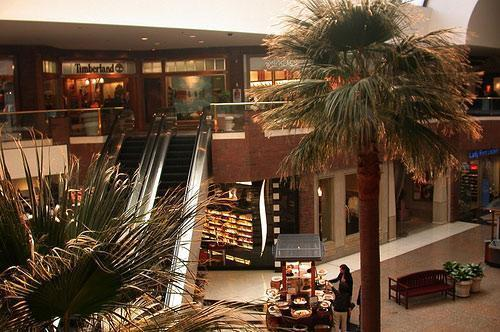

In [ ]:
image = open_image(pv.test.SEG_IMAGE)
image

In [ ]:
#|export
@delegates(open_image)
def open_mask(path, gray=True, **kwargs) -> Image.Image:
    return open_image(path, gray=gray, **kwargs)

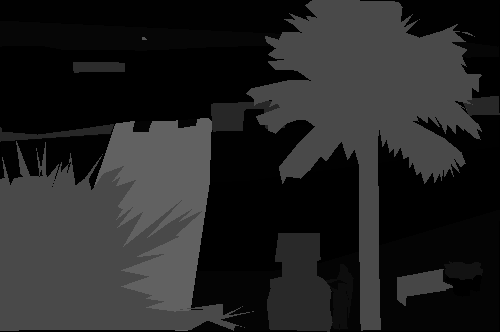

In [ ]:
open_mask(pv.test.SEG_MASK)

In [ ]:
#|export
def save_image(image, path):
    if isinstance(image, np.ndarray): image = Image.fromarray(image)
    return image.save(str(path))

In [ ]:
with tempfile.TemporaryDirectory() as d:
    path = Path(d)/'test.png'
    save_image(image, path)
    image_ = open_image(path)
    test_eq(np.array(image), np.array(image_))

In [ ]:
#|export
def _get_files(p, fs, extensions=None):
    "COPIED FROM https://github.com/fastai/fastai/blob/master/nbs/05_data.transforms.ipynb"
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
#|export
def get_files(path, extensions=None, recurse=True, folders=None, followlinks=True):
    """Get all the files in `path` with optional `extensions`, optionally with `recurse`, only in `folders`, if specified.
    COPIED FROM https://github.com/fastai/fastai/blob/master/nbs/05_data.transforms.ipynb
    """
    path = Path(path)
    folders=L(folders)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path, followlinks=followlinks)): # returns (dirpath, dirnames, filenames)
            if len(folders) !=0 and i==0: d[:] = [o for o in d if o in folders]
            else:                         d[:] = [o for o in d if not o.startswith('.')]
            if len(folders) !=0 and i==0 and '.' not in folders: continue
            res += _get_files(p, f, extensions)
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        res = _get_files(path, f, extensions)
    return L(res)

In [ ]:
test_eq(len(get_files(pv.test.ROOT_DIR/'segmentation', extensions='.png')), 2)

In [ ]:
#|export
class ImageFile(type(Path()), metaclass=BypassNewMeta):
    _bypass_type=type(Path())
    _extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))
    def __new__(cls, *pathsegments):
        return super().__new__(cls, *pathsegments)
    
    @delegates(open_image)
    def open(self, **kwargs): return open_image(self, **kwargs)
    def draw(self, drawer): return drawer.open_image(self)

In [ ]:
image_file = ImageFile(str(pv.test.SEG_IMAGE))
assert isinstance(image_file.parent/'test', ImageFile)
str(image_file.parent/'test')

'/home/lgvaz/git/polvo/assets/segmentation/test'

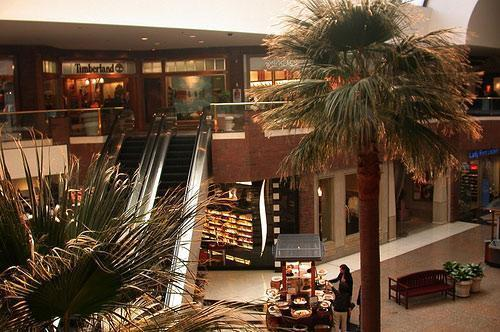

In [ ]:
ImageFile(str(pv.test.SEG_IMAGE)).open()

In [ ]:
#|export
def get_image_files(path, recurse=True, folders=None):
    """Get image files in `path` recursively, only in `folders`, if specified.
    COPIED FROM https://github.com/fastai/fastai/blob/master/nbs/05_data.transforms.ipynb
    """
    files = get_files(path, extensions=ImageFile._extensions, recurse=recurse, folders=folders)
    return [ImageFile(str(f)) for f in files]

In [ ]:
test_eq(len(get_image_files(pv.test.ROOT_DIR/'segmentation')), 2)

In [ ]:
#|export
def glob_match(dirpath, matches: Sequence[str], recursive=True):
    glob = Path.rglob if recursive else Path.glob
    return [f for match in matches for f in glob(Path(dirpath), match)]

In [ ]:
glob_match(pv.test.ROOT_DIR, ['*.png'])

[Path('/home/lgvaz/git/polvo/assets/polvo.png'),
 Path('/home/lgvaz/git/polvo/assets/segmentation/mask1.png'),
 Path('/home/lgvaz/git/polvo/assets/segmentation/image1.png')]

In [ ]:
glob_match(pv.test.ROOT_DIR, ['*.png'], recursive=False)

[Path('/home/lgvaz/git/polvo/assets/polvo.png')]

In [ ]:
#|export
class RenderDict:
    "From https://www.reddit.com/r/IPython/comments/34t4m7/lpt_print_json_in_collapsible_format_in_ipython/"
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        from IPython.display import display_javascript, display_html, display
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

In [ ]:
RenderDict({'h1': {'h2.1': [1, 2, 3, 4], 'h2.2': 'a'}})

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()